In [1]:
pip install vector uproot awkward

Note: you may need to restart the kernel to use updated packages.


In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward
import vector
plt.rcParams['figure.dpi'] = 100

import pandas as pd
import time
import vector

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import *
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

pot = 1.3e22
r_mue = 3e-17

seed_value = 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)


import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)

In [3]:
file_ce = uproot.open("Mu2eDriftAmbigCeMinusTracks.root")
file_dio = uproot.open("Mu2eDriftAmbigFlatDIOTracks.root")
trks_ce = file_ce['trks']
trks_dio = file_dio['trks']
p_ce = trks_ce.arrays(["px","py","pz"], aliases={"px": "kkmidmom/fCoordinates/fCoordinates.fX",
                                                    "py": "kkmidmom/fCoordinates/fCoordinates.fY",
                                                    "pz": "kkmidmom/fCoordinates/fCoordinates.fZ"})
p_dio = trks_dio.arrays(["px","py","pz"], aliases={"px": "kkmidmom/fCoordinates/fCoordinates.fX",
                                                   "py": "kkmidmom/fCoordinates/fCoordinates.fY",
                                                   "pz": "kkmidmom/fCoordinates/fCoordinates.fZ"})
p_mc_ce = trks_ce.arrays(["px","py","pz"], aliases={"px": "mcmidmom/fCoordinates/fCoordinates.fX",
                                                    "py": "mcmidmom/fCoordinates/fCoordinates.fY",
                                                    "pz": "mcmidmom/fCoordinates/fCoordinates.fZ"})
p_mc_dio = trks_dio.arrays(["px","py","pz"], aliases={"px": "mcmidmom/fCoordinates/fCoordinates.fX",
                                                      "py": "mcmidmom/fCoordinates/fCoordinates.fY",
                                                      "pz": "mcmidmom/fCoordinates/fCoordinates.fZ"})
ce_tinfo = trks_ce['tinfo'].arrays(library='pd')
ce_tinfo['kkmidt0'] = trks_ce['kkmidt0'].arrays(library='pd')
ce_tinfo['kkmidmomerr'] = trks_ce['kkmidmomerr'].arrays(library='pd')
ce_tinfo['weight'] = trks_ce['weight'].array()
ce_tinfo['kkmidmom'] = vector.awk(p_ce).mag
ce_tinfo['mcmidmom'] = vector.awk(p_mc_ce).mag
ce_tinfo[ce_tinfo['kkstatus'] <= 1]
ce_tinfo['class'] = 1

dio_tinfo = trks_dio['tinfo'].arrays(library='pd')
dio_tinfo['kkmidt0'] = trks_dio['kkmidt0'].arrays(library='pd')
dio_tinfo['kkmidmomerr'] = trks_dio['kkmidmomerr'].arrays(library='pd')
dio_tinfo['weight'] = trks_dio['weight'].array()
dio_tinfo['kkmidmom'] = vector.awk(p_dio).mag
dio_tinfo['mcmidmom'] = vector.awk(p_mc_dio).mag
dio_tinfo['class'] = 0
dio_tinfo[dio_tinfo['kkstatus'] <= 1]
dio_tinfo = dio_tinfo
full = pd.concat([ce_tinfo, dio_tinfo],ignore_index=True)
good_quality = (full['kkstatus'] <= 1)
bad_quality = (full['kkstatus'] <= 1) 
full.head()

,ncells,narcs,ntrkhits,ncalohits,kkstatus,kkndof,kknbf,kknmat,kknhit,kkniter,kknactive,kknnull,kkchisq,kkprob,kkmidt0,kkmidmomerr,weight,kkmidmom,mcmidmom,class
0,42,3,41,1,0,46,74,42,42,0,39,13,70.016914,1.276834e-02,896.078186,0.119351,0.000319,104.953762,104.661412,1
1,42,3,40,1,0,44,79,42,41,0,39,11,57.068371,8.938216e-02,909.713684,0.157844,0.000319,104.003335,103.926295,1
2,65,4,61,1,0,70,93,65,62,0,62,14,77.811592,2.441538e-01,323.670502,0.112756,0.000319,103.478819,103.488916,1
3,64,3,60,1,0,70,103,64,61,0,51,25,191.830017,2.786454e-13,1063.765259,0.154282,0.000319,103.665509,103.707688,1
4,31,2,30,1,0,35,69,31,31,0,30,11,73.173729,1.652358e-04,406.672119,0.280964,0.000319,102.539806,104.489867,1


In [4]:
train_sample = full[good_quality | bad_quality]
train_sample['quality'] = (np.abs(full['kkmidmom']-full['mcmidmom']) < 0.1).astype(int)
train_sample['mcmidmom']= full['mcmidmom']
train_sample['kkmidmom']=full['kkmidmom']
test_size = 0.4
seed = 7
X, Y = train_sample.loc[:, train_sample.columns!=('mcmidmom')], train_sample['mcmidmom']


#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1) #60/20/20 split


#remove weight
#adjust hyperparameters 
X_train_df = X_train.loc[:, X_train.columns.isin(['kkmidmom','kkmidt0','kkmidmomerr', 'kkprob', 'kkchisq','kknhit'])] #values im training with 
X_train_df.head()
X_test_df=X_test.loc[:, X_test.columns.isin(['kkmidmom','kkmidt0','kkmidmomerr', 'kkprob', 'kkchisq','kknhit'])] 
X_val_df = X_val.loc[:, X_train.columns.isin(['kkmidmom','kkmidt0','kkmidmomerr', 'kkprob', 'kkchisq','kknhit'])] #val

#kknhit

/tmp/ipykernel_108/2444933583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sample['quality'] = (np.abs(full['kkmidmom']-full['mcmidmom']) < 0.1).astype(int)
/tmp/ipykernel_108/2444933583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sample['mcmidmom']= full['mcmidmom']
/tmp/ipykernel_108/2444933583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [5]:
#scaler = StandardScaler().fit_transform(X_train_df)
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_df)
X_test_scaled = sc.transform (X_test_df)
#X_train_scaled = scaler.transform(X_train_df)
print(X_train_scaled.mean(axis=0))
print(X_train_scaled.std(axis=0))
#scaler_test = StandardScaler().fit(X_test)
#X_test_scaled = scaler.transform(X_test_df)
X_val_scaled = sc.transform(X_val_df)
print(X_test_scaled.mean(axis=0))
print(X_test_scaled.std(axis=0))
#fit scaler using training data only, then standardize both. (looked up if should scale dataset before or after split, and it was recommended to scale after split to avoid data leakage?)
#before was using scaler on both X_train and X_test
print(X_val_scaled.mean(axis=0))
print(X_val_scaled.std(axis=0))

#fix notebook/make it presentable

X_train_df.head()

[-1.76211158e-16  4.13650049e-17  2.25505128e-17 -7.53117244e-17
 -9.07396080e-17  3.21476508e-15]
[1. 1. 1. 1. 1. 1.]
[ 0.0121161   0.0072767  -0.00784803 -0.01780509 -0.00485282  0.00439601]
[1.00725496 0.953214   1.00063542 0.9870866  0.98660165 0.99403639]
[-7.12061639e-04 -6.51178937e-03  2.31434598e-06 -7.46192530e-03
  9.31725203e-03  7.31578796e-03]
[1.00510194 0.98010369 0.99816264 0.99856727 1.03363672 0.9955778 ]


,kknhit,kkchisq,kkprob,kkmidt0,kkmidmomerr,kkmidmom
81892,36,95.018723,8.737193e-07,680.820679,0.236629,99.640642
74572,32,33.779091,4.296862e-01,1586.905273,0.207664,99.567772
5836,33,61.865784,3.385042e-03,369.434814,0.194996,103.630213
12225,21,30.836308,9.951404e-02,609.083984,0.288090,104.210773
15969,29,42.557438,3.838677e-02,290.015900,0.220144,103.616945


In [6]:
regressor = MLPRegressor(activation="relu",solver='adam',hidden_layer_sizes=(15,5),shuffle=False,random_state=7,early_stopping=True,max_iter=250)

#regressor = MLPRegressor(shuffle=False,random_state=7,early_stopping=True,max_iter=250)
#shuffle = false so each run is consistent + random state = 7
#(3,10)
#try log

regressor.fit(X_train_scaled, y_train)
y_pred = regressor.predict(X_test_scaled) #use test sample 
#y_val=regressor.predict(X_val)
regressor.score(X_test_scaled,y_test) #use test sample** train sample only for training
#3 to 1

#increasing hidden layer sizes leads to completely flat validation curve i.e. 15,5
#7,2 validation curve starts at negative number...
#increasing second layer after first yields strange results
#neurons should be in between input(7) / output layer(1)
#loss should be lower on training 

#1 hidden layer wasn't enough, try tune 2 

#other things to consider: try tuning training/testing split? 
#increasing # of epochs barely changes
#change input variables/ try with/without kknhit etc?

#try normalizing variables *standardscaler #dist around 0

#first lower/higher (3,6 best) 5,15
#3 layers (3,6,x) etc overfit



0.9329924861646992

Text(0.5, 1.0, 'MLP Regressor')

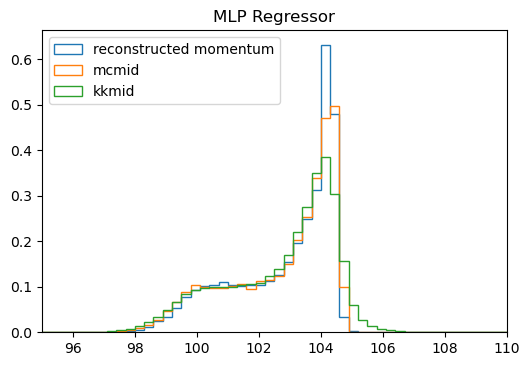

In [7]:
#1 hidden layer
bins=50
plt.hist(y_pred, bins, alpha=1, label='reconstructed momentum', density=True, histtype='step',range=(95,110))
plt.hist(y_test, bins, alpha=1, label='mcmid', density=True, histtype='step',range=(95,110))
plt.hist(train_sample['kkmidmom'], bins, alpha=1, label='kkmid', density=True, histtype='step',range=(95,110))
plt.xlim(95,110)
plt.legend(loc='upper left')
plt.title('MLP Regressor')



In [8]:
X_train_scaled

array([[-0.38497121,  0.6516823 , -0.57582598, -0.54689389,  0.49980754,
        -1.72038196],
       [-0.709524  , -1.12397658,  1.47138096,  0.49540573,  0.21389037,
        -1.76102211],
       [-0.6283858 , -0.30959569, -0.55970234, -0.90509154,  0.08884733,
         0.50463365],
       ...,
       [ 0.42641075, -0.33473913,  0.07700385,  0.01316415, -0.84900934,
         0.84388004],
       [-1.35862957, -1.35264976,  0.88192642, -0.05946639,  1.60955453,
        -0.91785267],
       [-1.03407678, -0.19768217, -0.57498682, -0.71553896,  1.86849027,
        -2.14241999]])

In [9]:
def iterative_fit(algorithm, X_train_scaled, y_train, X_test_scaled, y_test, max_epochs):
    model = algorithm
    scores = {'train':[], 'test':[]}
    for i in range(max_epochs):
        
        model.partial_fit(X_train_scaled, y_train)
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        scores['train'].append(train_score)
        scores['test'].append(test_score)
 
    return scores, model
#fit with the models scoring method R^2
algorithm = MLPRegressor(random_state=7)
#algorithm = MLPRegressor(activation="relu",solver='adam',hidden_layer_sizes=(50,25),shuffle=False,random_state=7,early_stopping=True,max_iter=1000)
iterative_scores, mlp_model = iterative_fit(algorithm, X_train_scaled, y_train, X_test_scaled, y_test, max_epochs=250)
iterative_scores

{'train': [-1845.4251228197263,
  -288.8960084591482,
  -105.33589539330379,
  -68.10296854909095,
  -48.08515075615428,
  -34.05292857335123,
  -23.47664171582342,
  -15.20724944540531,
  -9.25279216861205,
  -5.36194187175056,
  -2.9984671844835136,
  -1.5954406976431694,
  -0.7583450592286005,
  -0.2534412347369521,
  0.057127864327921385,
  0.25436319727574763,
  0.38807207799507226,
  0.4863202214485063,
  0.562283452416106,
  0.6238965016658091,
  0.6741403140258676,
  0.7165184956868161,
  0.752102227849389,
  0.7816240603243625,
  0.8056174946172432,
  0.8253931841346132,
  0.841761328343963,
  0.8545103488037333,
  0.8645383290525417,
  0.8718430641674737,
  0.8778758889921002,
  0.8844337563313812,
  0.8920749267854593,
  0.8993247257235559,
  0.9049485785351217,
  0.909154952597509,
  0.9122041142270638,
  0.9148045820485048,
  0.9170654585271932,
  0.9190310033979763,
  0.9205911815718382,
  0.9219528657967735,
  0.9232268021315403,
  0.9244097422651881,
  0.925483159980272

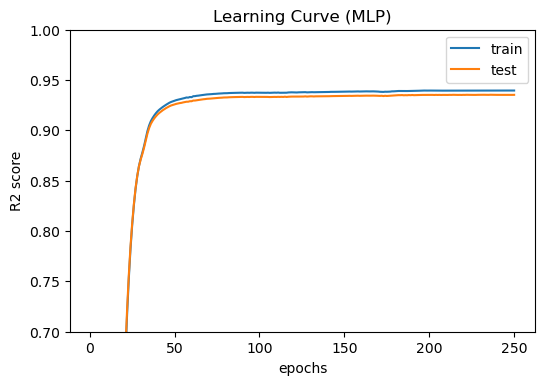

<Figure size 600x400 with 0 Axes>

In [10]:
epochs = range(1, len(iterative_scores['train'])+1)
plt.plot(epochs, iterative_scores['train'], label='train')
plt.plot(epochs, iterative_scores['test'], label='test')
plt.title('Learning Curve (MLP)')
plt.xlabel('epochs')
plt.ylabel('R2 score')
plt.ylim(.7,1)
plt.legend()
plt.show()
fig = plt.figure()


In [26]:
epochs = 250

regressor2 = MLPRegressor(activation="relu",
                   max_iter=1,
                   solver="adam",
                   random_state=7,
                   early_stopping=False,
                   hidden_layer_sizes=(50,25,15))




from sklearn.metrics import mean_squared_error
training_mse = []
validation_mse = []

for epoch in range(epochs):
    regressor2.partial_fit(X_train_scaled, y_train) 
    y_pred2 = regressor2.predict(X_train_scaled)
    curr_train_score = mean_squared_error(y_train, y_pred2) 
    y_pred2 = regressor2.predict(X_val_scaled) 
    curr_valid_score = mean_squared_error(y_val, y_pred2) 
    training_mse.append(curr_train_score)                  
    validation_mse.append(curr_valid_score)               

(0.0, 200.0)

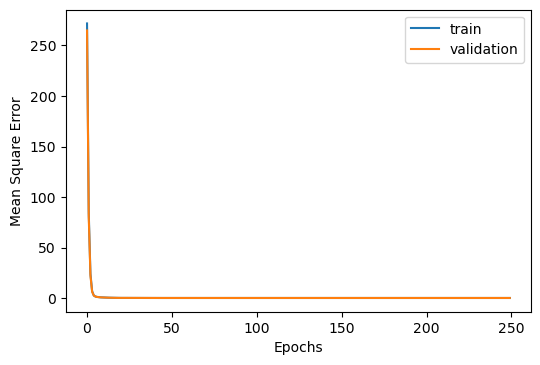

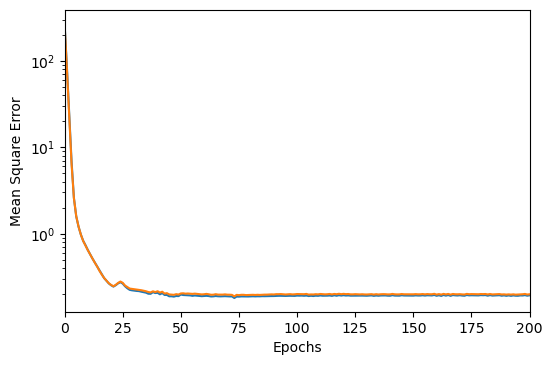

In [27]:
plt.plot(training_mse,label="train")
plt.plot(validation_mse,label="validation")
plt.ylabel('Mean Square Error')
plt.xlabel('Epochs')

plt.legend()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(training_mse,label="train")
ax.plot(validation_mse,label="validation")
ax.set_ylabel('Mean Square Error')
ax.set_xlabel('Epochs')

ax.set_yscale('log')
ax.set_xlim(0,200)


#plot log scale

In [28]:
training_mse

[271.72283569536955,
 84.74050820664111,
 24.19566259021449,
 6.859137384263565,
 2.610196557371731,
 1.5894556801961754,
 1.204394305252445,
 0.9743178632440179,
 0.8256053897608273,
 0.7341857026759173,
 0.6459271739982057,
 0.5751404638747086,
 0.5136229506253304,
 0.46250407232514945,
 0.41882590200640163,
 0.3737445032347838,
 0.3362098226845582,
 0.3055563080344881,
 0.2839990539219205,
 0.26509986188345624,
 0.2523669105698243,
 0.24348612286335605,
 0.25249678596697545,
 0.2650214823891787,
 0.2740832914205575,
 0.263796414271035,
 0.2455032902537952,
 0.23270129731716369,
 0.2231937783642329,
 0.2204541943807488,
 0.2184637576963116,
 0.21679611763925732,
 0.21584835009045644,
 0.21244146058135657,
 0.21000243592996065,
 0.20708040878995007,
 0.20142478725046797,
 0.20084790694604343,
 0.2099098207841503,
 0.20498489027441533,
 0.20634951606357593,
 0.19825930672978961,
 0.20462519287684133,
 0.19472068760179614,
 0.1947882351577414,
 0.18798483929425203,
 0.18806617620148533,

In [29]:
validation_mse

[264.8074511970165,
 80.36624404939354,
 22.481742942809415,
 6.397751213621946,
 2.576431859909836,
 1.5927441430413618,
 1.2047315328429644,
 0.9734260002717173,
 0.8211820281283908,
 0.7263917197783359,
 0.6411689477607517,
 0.572978486750367,
 0.5113359831958113,
 0.4603713802683588,
 0.41561103593004006,
 0.37062449088918664,
 0.33542477897607054,
 0.3062800110767188,
 0.28542840937099206,
 0.2665432554856282,
 0.25435021972949795,
 0.2458074904522629,
 0.2551116448856433,
 0.26863009917604397,
 0.27863170210427896,
 0.2692671896093913,
 0.25026030315668796,
 0.24004835500048755,
 0.23102054034152805,
 0.22906316972612137,
 0.22686231689035766,
 0.22524404283306224,
 0.22382485213336248,
 0.2209642050529118,
 0.21815667494116156,
 0.2150525540306818,
 0.21061441587159896,
 0.20841160069893797,
 0.21477879983631235,
 0.21022418957235794,
 0.21525596432919059,
 0.20743896041789092,
 0.2124263497831013,
 0.20205752645526628,
 0.20446036270354137,
 0.19765293672063614,
 0.196558070136


regressor3 = MLPRegressor(early_stopping:True,random_state:7,shuffle:False)
param_grid = {
    'hidden_layer_sizes': [(100,50), (50,25), (70,25),(100,50,25)],
    'max_iter': [1000,2000,3000],
    'activation': ['tanh', 'relu','logistic','lbfgs'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}
    #'early_stopping':['True'],
    #'random_state':[7],
    #'shuffle':['False'] 


grid = GridSearchCV(regressor3, param_grid, n_jobs= -1, cv=3)
grid.fit(X_train_scaled, y_train)


In [15]:
len(y_pred)

22030

In [16]:
y_test

75369     102.596030
93488     102.405622
64539      99.665772
111045    101.994672
43395     104.680013
             ...    
58530     102.292525
60650     100.705356
107054    103.427385
58502     100.039728
52110     103.753876
Name: mcmidmom, Length: 22030, dtype: float64

In [17]:
pl

NameError: name 'pl' is not defined